# Cleaning TUIK Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import re
import json
import missingno as msno

In [2]:
path_to_data = 'data/TUIK'
file_names = os.listdir(path_to_data)
file_names

['consumer_confidence_index.csv',
 'consumer_price_index.csv',
 'export_import.xlsx',
 'export_import1.xls',
 'export_import2.xls',
 'export_import3.xls',
 'export_import4.xls',
 'export_unit_value_index.csv',
 'gdp_expenditure.csv',
 'gdp_income.csv',
 'gdp_production1.csv',
 'gdp_production2.csv',
 'gdp_production3.csv',
 'gdp_production_original.csv',
 'import_unit_value_index.csv',
 'industrial_production_index1.csv',
 'industrial_production_index2.csv',
 'unemployment1.xlsx',
 'unemployment1_original.xls',
 'unemployment2.csv']

### Export-Import data

In [55]:
def clean_import_export(read_path, save_path=None, save_data=False, return_data=True):

    df = pd.read_excel(path)
    
    df = df.dropna(how='all')

    # Renaming columns
    df = df.rename(columns={'Yıl': 'year', 'Ay': 'month', 'İhracat Dolar': 'exports_usd',
               'İhracat TL/YTL': 'exports_tl', 'İthalat Dolar': 'imports_usd', 'İthalat TL/YTL': 'imports_tl'})

    # Filling empty year values
    df['year'] = df['year'].fillna(method='ffill').astype('int')

    # Dropping "Toplam" rows
    cond = df['month'].astype('str').str.isnumeric()
    df = df.loc[cond]
    df['month'] = df['month'].astype('int').copy()

    # Removing period from numeric columns and converting to int 
    cols = ['exports_usd', 'exports_tl', 'imports_usd', 'imports_tl']

    for col in cols:
        df[col] = df[col].str.replace('.', '', regex=False)
        df[col] = df[col].astype('int64')
    
    # Adding date column
    df['day'] = 1
    df.insert(0, 'date', pd.to_datetime(df[['year', 'month', 'day']]))
    df = df.drop(columns=['day'])
    
    # Saving data
    if save_data:
        assert save_path is not None, "Provide save_path"
        df.to_csv(save_path, index=False)
    
    if return_data:
        return df

In [56]:
file_name = 'export_import.xlsx'
read_path = os.path.join(path_to_data, file_name)
save_path = 'cleaned_data/export_import.csv'
# clean_import_export(read_path, save_path, save_data=True, return_data=False)

In [61]:
# Loading cleaned data
df = pd.read_csv('cleaned_data/export_import.csv', parse_dates=['date'])

In [62]:
df.head()

,date,year,month,exports_usd,exports_tl,imports_usd,imports_tl
0,2005-01-01,2005,1,4997279724,6791013684,7219679862,9812593440
1,2005-02-01,2005,2,5651741252,7449079145,8323736797,10998599631
2,2005-03-01,2005,3,6591859218,8638660740,10196352932,13302963657
3,2005-04-01,2005,4,6128131878,8333848266,9595500303,13036202298
4,2005-05-01,2005,5,5977226217,8198283737,9811620456,13450174257


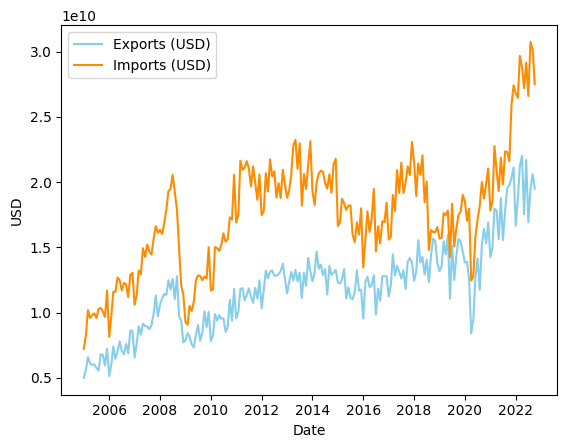

In [63]:
plt.plot('date', 'exports_usd', data=df, color='skyblue', label='Exports (USD)')
plt.plot('date', 'imports_usd', data=df, color='darkorange', label='Imports (USD)')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.show()

## GDP data
There are 5 files for GDP:
* gdp_expenditure: Gross Domestic Product  By Expenditure Approach (2009 Base)
    * Current Prices and Thousand Try and B1GQ. (Gross Domestic Product (Gdp))
    
* gdp_income: Gross Domestic Product  By Income Approach (2009 Base)
    * Current Prices and Thousand Try and B1GQ. (Gross Domestic Product (Gdp))
    
* gdp_production: Gross Domestic Product  By Production Approach (2009 Base). The original file (gdp_production_original) has GDp by production approach computed using three methods. I divided the original file into three files for easier processing:
    * gdp_production1:
        * Current Prices and Thousand Try and B1G. (Gross Value Added)
    * gdp_production2:
        * Current Prices and Thousand Try and B1GQ. (Gross Domestic Product (Gdp))
    * gdp_production3:
        * Current Prices and Thousand Try and D21X31. (Taxes Less Subsidies On Products)

In [3]:
def clean_gdp_data(read_path, save_path=None, save_data=False, return_data=True):
    
    df = pd.read_csv(path, sep='|', skiprows=3, header=None)
    
    df = df.iloc[:, 3:8]
    
    df.columns = ['year', 'q1', 'q2', 'q3', 'q4']
    
    df = df.dropna(how='all')
    
    # Converting data types
    df['year'] = df['year'].astype('int')
    
    # Melting dataframe
    df = df.melt(id_vars=['year'], value_vars=['q1', 'q2', 'q3', 'q4'])
    
    m = re.compile(r'.*(gdp_\w+)\.csv$')
    name = re.search(m, path).group(1)

    df = df.rename(columns={'value': name, 'variable': 'quarter'})
    df = df.dropna()
    
    df['quarter'] = df['quarter'].apply(lambda x: x[1]).astype('int')
    
    # Adding date column
    df['day'] = 1
    df['month'] = df['quarter'].replace({1: 3, 2: 6, 3:9, 4:12})
    df.insert(0, 'date', pd.to_datetime(df[['year', 'month', 'day']]))
    df = df.drop(columns=['day', 'month'])
             
    df = df.sort_values(by='date')
    
    # Saving data
    if save_data:
        assert save_path is not None, "Provide save_path"
        df.to_csv(save_path, index=False)
    
    if return_data:
        return df
    
    return df

In [19]:
gdp_files = [
    'gdp_expenditure.csv',
    'gdp_income.csv',
    'gdp_production1.csv',
    'gdp_production2.csv',
    'gdp_production3.csv'
]

path_to_data = 'data/TUIK'

df_list = []

for file_name in gdp_files:
    path = os.path.join(path_to_data, file_name)
    df = clean_gdp_data(path, return_data=True)
    df_list.append(df)

# Merging data
merged_df = df_list[0].copy()
for df in df_list[1:]:
    merged_df = merged_df.merge(df, on=['date', 'year', 'quarter'])

In [20]:
merged_df.head()

,date,year,quarter,gdp_expenditure,gdp_income,gdp_production1,gdp_production2,gdp_production3
0,2005-03-01,2005,1,142588340.0,142588340.0,125072561.0,142588340.0,17515778.0
1,2005-06-01,2005,2,163510888.0,163510888.0,142322731.0,163510888.0,21188157.0
2,2005-09-01,2005,3,186658293.0,186658293.0,163591890.0,186658293.0,23066403.0
3,2005-12-01,2005,4,187518326.0,187518326.0,163896094.0,187518326.0,23622232.0
4,2006-03-01,2006,1,162557040.0,162557040.0,141101974.0,162557040.0,21455066.0


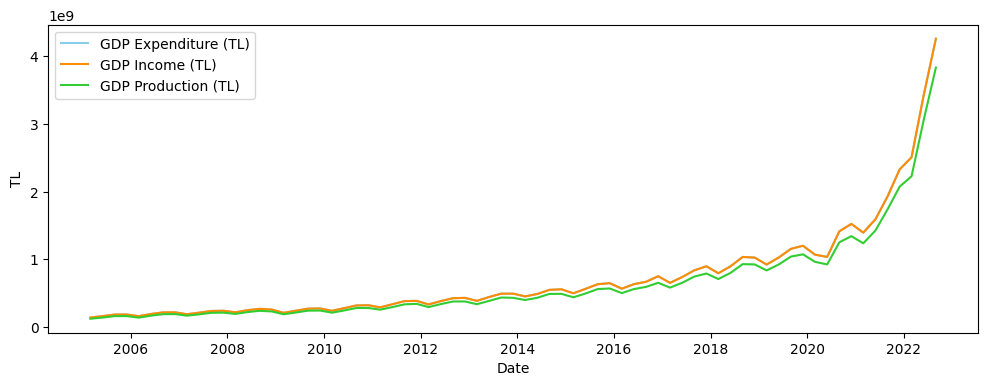

In [23]:
plt.figure(figsize=(12, 4))
plt.plot('date', 'gdp_expenditure', data=merged_df, color='skyblue', label='GDP Expenditure (TL)')
plt.plot('date', 'gdp_income', data=merged_df, color='darkorange', label='GDP Income (TL)')
plt.plot('date', 'gdp_production1', data=merged_df, color='limegreen', label='GDP Production (TL)')
plt.xlabel('Date')
plt.ylabel('TL')
plt.legend()
plt.show()

The variables are highly correlated. We can use only one value.

In [25]:
merged_df.iloc[:, 3:].corr()

,gdp_expenditure,gdp_income,gdp_production1,gdp_production2,gdp_production3
gdp_expenditure,1.000000,1.000000,0.999954,1.000000,0.996535
gdp_income,1.000000,1.000000,0.999954,1.000000,0.996535
gdp_production1,0.999954,0.999954,1.000000,0.999954,0.995688
gdp_production2,1.000000,1.000000,0.999954,1.000000,0.996535
gdp_production3,0.996535,0.996535,0.995688,0.996535,1.000000


In [26]:
df = merged_df.iloc[:, :4].rename(columns={'gdp_expenditure': 'gdp'})

In [29]:
# Saving data
df.to_csv('cleaned_data/gdp.csv', index=False)

In [30]:
df = pd.read_csv('cleaned_data/gdp.csv', parse_dates=['date'])

In [31]:
df.head()

,date,year,quarter,gdp
0,2005-03-01,2005,1,142588340.0
1,2005-06-01,2005,2,163510888.0
2,2005-09-01,2005,3,186658293.0
3,2005-12-01,2005,4,187518326.0
4,2006-03-01,2006,1,162557040.0


## Consumer Price Index (2003=100)

In [140]:
def clean_cpi_data(read_path, save_path=None, save_data=False, return_data=True):
    
    df = pd.read_csv(read_path, sep='|', skiprows=4, header=None)

    df = df.iloc[:, 2:15]
    
    df.columns = ['year'] + list(range(1, 13))

    df = df.dropna(how='all')
    
    # Converting data types
    df['year'] = df['year'].astype('int')
    
    # Melting dataframe
    df = df.melt(id_vars=['year'], value_vars=df.columns[1:])

    df = df.rename(columns={'value': 'consumer_price_index', 'variable': 'month'})
    df = df.dropna()
    
    # Adding date column
    df['day'] = 1
    df['month'] = df['month'].astype('int')
    df.insert(0, 'date', pd.to_datetime(df[['year', 'month', 'day']]))
    df = df.drop(columns=['day'])
             
    df = df.sort_values(by='date')
    
    # Saving data
    if save_data:
        assert save_path is not None, "Provide save_path"
        df.to_csv(save_path, index=False)
    
    if return_data:
        return df

In [122]:
path = 'data/TUIK/consumer_price_index.csv'
save_path = 'cleaned_data/consumer_price_index.csv'
# df = clean_cpi_data(path, save_data=True, save_path=save_path)

In [132]:
df = pd.read_csv('cleaned_data/consumer_price_index.csv', parse_dates=['date'])

In [133]:
df.head()

,date,year,month,consumer_price_index
0,2005-01-01,2005,1,114.49
1,2005-02-01,2005,2,114.51
2,2005-03-01,2005,3,114.81
3,2005-04-01,2005,4,115.63
4,2005-05-01,2005,5,116.69


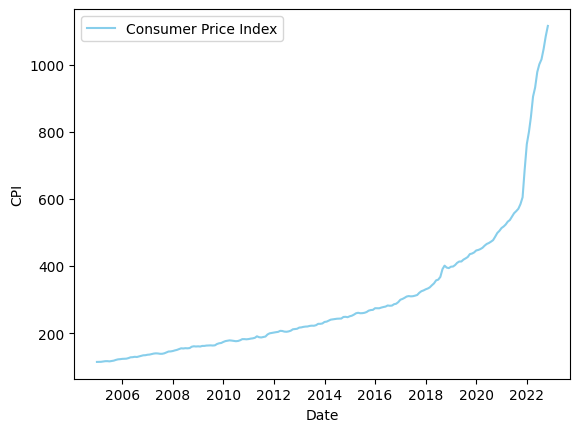

In [134]:
plt.plot('date', 'consumer_price_index', data=df, color='skyblue', label='Consumer Price Index')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

## Export and Import Unit Value Index (2010=100)
The file **export_unit_value_index.csv** contains this index in both TL and USD. Only the USD value will be kept in the cleaned file. However, the TL value can be retrieved when necessary. In addition, we can use the USD/TL rate in this file as rate for all TL --> USD conversions we make in this project.

### Notes:
* The value of the index in TL is lower than its value in USD in some years (like 2005 and 2006). However at that time 1 USD was about 1.5 TL, so if the two indexes are the same the USD index should have a lower value. Is this index computed differently in USD and TL?

In [235]:
def clean_export_import_unit_val_index_data(read_path, which, save_path=None, save_data=False, return_data=True):
    '''
    which should be "import" or "export".
    '''
    df = pd.read_csv(read_path, sep='|', skiprows=4, header=None)

    if which == 'export':
        df = df.iloc[:, 1:27]
        df = df.drop(columns=[2])
        
    elif which == 'import':
        df = df.iloc[:, 2:27]
    
    tl_columns = list(map(lambda x: f'{x}_tl', range(1, 13)))
    usd_columns = list(map(lambda x: f'{x}_usd', range(1, 13)))
    df.columns = ['year'] + tl_columns + usd_columns
    
    df = df.dropna(how='all')
    
    # Converting data types
    df['year'] = df['year'].astype('int')
    
    df_usd = df[['year'] + usd_columns].copy()
    df_tl = df[['year'] + tl_columns].copy()

    # Variable name
    idx = len(read_path) - read_path[::-1].find('/') - 1
    name = read_path[idx+1:-4]
    
    df_list = []
    
    for df in [df_usd, df_tl]:
        # Converting column names back to months
        df.columns = ['year'] + list(range(1, 13))
        
        # Melting dataframe
        df = df.melt(id_vars=['year'], value_vars=df.columns[1:])
        df = df.rename(columns={'value': name, 'variable': 'month'})
        df = df.dropna()
        
        # Adding date column
        df['day'] = 1
        df['month'] = df['month'].astype('int')
        df.insert(0, 'date', pd.to_datetime(df[['year', 'month', 'day']]))
        df = df.drop(columns=['day'])
        
        df = df.sort_values(by='date')
        
        df_list.append(df)
    
    # Merging USD and TL dataframes
    df = df_list[0].merge(df_list[1], on=['date', 'year', 'month'], suffixes=('_usd', '_tl'))
    
    # Saving data
    if save_data:
        assert save_path is not None, "Provide save_path"
        df.to_csv(save_path, index=False)
    
    if return_data:
        return df

In [241]:
read_path = 'data/TUIK/export_unit_value_index.csv'
save_path = 'cleaned_data/export_unit_value_index.csv'

# df = clean_export_import_unit_val_index_data(read_path, which='export', save_data=True, save_path=save_path)

In [248]:
# Loading data
save_path = 'cleaned_data/export_unit_value_index.csv'
df = pd.read_csv(save_path, parse_dates=['date'])

In [249]:
df.head()

,date,year,month,export_unit_value_index_usd,export_unit_value_index_tl
0,2005-01-01,2005,1,86.8,78.4
1,2005-02-01,2005,2,86.5,75.8
2,2005-03-01,2005,3,87.9,76.6
3,2005-04-01,2005,4,86.6,78.3
4,2005-05-01,2005,5,86.6,78.9


Notice how the USD index values sometimes exceeded the TL index value, indicating that the value of TL was higher than the value of USD at that time (under the assumption that the index value is computed in the same way for both USD and TL, the only difference being the currency).

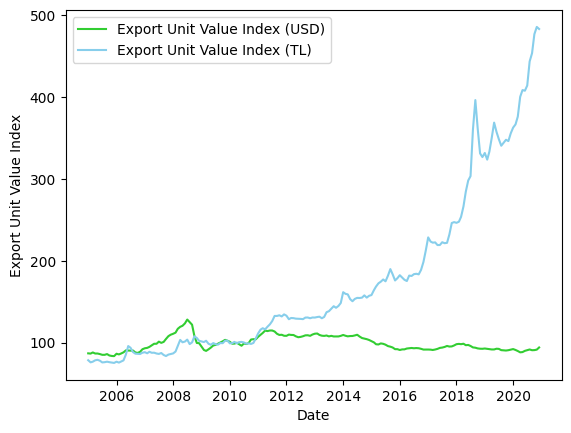

In [243]:
plt.plot('date', 'export_unit_value_index_usd', data=df, color='limegreen', label='Export Unit Value Index (USD)')
plt.plot('date', 'export_unit_value_index_tl', data=df, color='skyblue', label='Export Unit Value Index (TL)')
plt.xlabel('Date')
plt.ylabel('Export Unit Value Index')
plt.legend()
plt.show()

In [244]:
read_path = 'data/TUIK/import_unit_value_index.csv'
save_path = 'cleaned_data/import_unit_value_index.csv'

# df = clean_export_import_unit_val_index_data(read_path, which='import', save_data=True, save_path=save_path)

In [11]:
# Loading data
save_path = 'cleaned_data/import_unit_value_index.csv'
df = pd.read_csv(save_path, parse_dates=['date'])

In [12]:
df.head()

,date,year,month,import_unit_value_index_usd,import_unit_value_index_tl
0,2005-01-01,2005,1,80.7,73.0
1,2005-02-01,2005,2,80.0,70.4
2,2005-03-01,2005,3,81.1,70.4
3,2005-04-01,2005,4,85.3,77.2
4,2005-05-01,2005,5,80.2,73.2


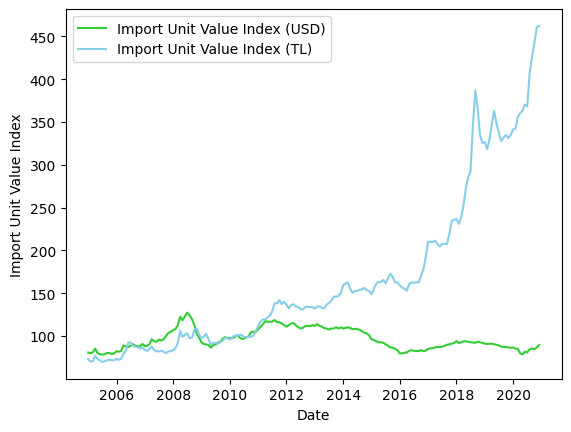

In [13]:
plt.plot('date', 'import_unit_value_index_usd', data=df, color='limegreen', label='Import Unit Value Index (USD)')
plt.plot('date', 'import_unit_value_index_tl', data=df, color='skyblue', label='Import Unit Value Index (TL)')
plt.xlabel('Date')
plt.ylabel('Import Unit Value Index')
plt.legend()
plt.show()

In [17]:
df['date'].dt.month_name()

0        January
1       February
2          March
3          April
4            May
         ...    
187       August
188    September
189      October
190     November
191     December
Name: date, Length: 192, dtype: object

## Unemployment Rates
There are two files for unemployment rates:
* unemployment1
* unemployment2

I manually converted unemployment1 to .xlsx format as the original .xls format is not readable in Pandas. The original file is saved as unemployment1_original.

#### Unemployment1

In [30]:
def clean_unemployment1(read_path, save_path=None, save_data=False, return_data=True):
    
    df = pd.read_excel(read_path)
    
    # Converting unemployment rates to floats
    for col in df.columns[1:]:
        df[col] = df[col].str.replace(',', '.')
        df[col] = df[col].astype('float')
    
    df.columns = ['date'] + list(map(lambda x: f'unemployment_{x.strip()}', df.columns[1:]))
    
    # Adding date columns
    year = df['date'].apply(lambda x: x.split(' ')[0])
    month = df['date'].apply(lambda x: x.split(' ')[1])
    date = year + '-' + month + '-01'
    df['date'] = pd.to_datetime(date)
    df.insert(1, 'year', df['date'].dt.year)
    df.insert(2, 'month', df['date'].dt.month)

    # Saving data
    if save_data:
        assert save_path is not None, "Provide save_path"
        df.to_csv(save_path, index=False)
    
    if return_data:
        return df

In [31]:
read_path = 'data/TUIK/unemployment1.xlsx'
df1 = clean_unemployment1(read_path)

In [32]:
df1.head()

,date,year,month,unemployment_15-19,unemployment_20-24,unemployment_25-29,unemployment_30-34,unemployment_35-39,unemployment_40-44,unemployment_45-49,unemployment_50-54,unemployment_55-59,unemployment_60-64,unemployment_65+
0,2014-01-01,2014,1,16.0,20.5,13.5,9.3,7.8,7.2,7.3,7.5,6.3,4.0,1.3
1,2013-01-01,2013,1,19.0,21.6,13.8,9.4,8.8,7.0,6.5,7.8,5.9,4.0,1.1
2,2013-02-01,2013,2,18.7,21.4,12.9,9.5,9.1,7.0,6.9,8.3,5.8,4.0,1.2
3,2013-03-01,2013,3,17.2,20.3,12.5,9.4,8.5,7.0,6.8,7.7,5.5,3.8,1.3
4,2013-04-01,2013,4,15.1,18.9,11.9,8.6,7.9,6.5,6.5,6.2,5.6,3.6,1.3


#### Unemployment2

In [33]:
def clean_unemployment2(read_path, save_path=None, save_data=False, return_data=True):
    
    df = pd.read_csv(read_path, sep='|', header=3)
    
    # Removing unnecessary columns
    df = df.iloc[:, 1:-1]
    df.columns = ['year', 'date'] + list(df.columns[2:])

    # Including the columns of 15+ only
    # There are other columns for 15-64 that do not match the columns in the older dataset
    cond = df.columns.str.contains('(15+)', regex=False)
    unemployment_cols = list(df.columns[cond])

    df = df[['date', 'year'] + unemployment_cols]

    # Renaming columns
    m = re.compile(r'1\. \(15\+\) and \d+\. \((.+)\)')
    new_col_names = list(map(lambda x: 'unemployment_' + re.search(m, x).group(1), unemployment_cols))
    rename_dict = dict(zip(unemployment_cols, new_col_names))
    df = df.rename(columns=rename_dict)

    df = df.dropna(how='all')

    # Adding date column
    df['year'] = df['year'].fillna(method='ffill').astype('int')
    df.insert(2, 'month', df['date'].str[:2].astype('int'))
    date = df['year'].astype('str') + '-' + df['month'].astype('str') + '-01'
    df['date'] = pd.to_datetime(date)

    # Saving data
    if save_data:
        assert save_path is not None, "Provide save_path"
        df.to_csv(save_path, index=False)
    
    if return_data:
        return df

In [34]:
read_path = 'data/TUIK/unemployment2.csv'
df2 = clean_unemployment2(read_path)

In [35]:
df2.head()

,date,year,month,unemployment_15-19,unemployment_20-24,unemployment_25-29,unemployment_30-34,unemployment_35-39,unemployment_40-44,unemployment_45-49,unemployment_50-54,unemployment_55-59,unemployment_60-64,unemployment_65+
0,2014-01-01,2014,1,15.0,19.1,12.9,9.8,8.2,7.9,7.8,8.0,7.0,4.8,1.4
1,2014-02-01,2014,2,15.0,18.0,13.1,9.2,8.1,7.8,8.1,8.4,7.6,4.4,1.8
2,2014-03-01,2014,3,15.1,17.6,12.3,8.6,7.3,7.6,7.6,8.0,7.9,4.6,2.0
3,2014-04-01,2014,4,14.7,16.0,11.9,8.0,6.8,6.5,6.4,7.9,7.1,4.2,2.4
4,2014-05-01,2014,5,16.0,15.7,11.6,7.8,6.5,5.8,6.2,7.6,6.8,4.1,2.4


The two datasets only overlap in January 2014. There is a slight difference between the two datasets for this month as shown below.

In [40]:
df1['date'].dt.year.unique()

array([2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005],
      dtype=int64)

In [41]:
df2['date'].dt.year.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [36]:
cond = df1['year'] == 2014
df1_ = df1[cond]

cond = df2['year'] == 2014
df2_ = df2[cond]

In [37]:
pd.concat([df1_, df2_.iloc[[0]]], axis=0)

,date,year,month,unemployment_15-19,unemployment_20-24,unemployment_25-29,unemployment_30-34,unemployment_35-39,unemployment_40-44,unemployment_45-49,unemployment_50-54,unemployment_55-59,unemployment_60-64,unemployment_65+
0,2014-01-01,2014,1,16.0,20.5,13.5,9.3,7.8,7.2,7.3,7.5,6.3,4.0,1.3
0,2014-01-01,2014,1,15.0,19.1,12.9,9.8,8.2,7.9,7.8,8.0,7.0,4.8,1.4


Merging the two unemployment datasets

In [47]:
df = pd.concat([df2, df1], ignore_index=True)

# Removing the duplicate value of Jan 2014
df = df.drop_duplicates(subset=['year', 'month'], keep='first').sort_values(by='date').reset_index(drop=True)

# Saving data
# df.to_csv('cleaned_data/unemployment.csv', index=False)

In [51]:
# Loading saved data
df = pd.read_csv('cleaned_data/unemployment.csv', parse_dates=['date'])

In [52]:
df.head()

,date,year,month,unemployment_15-19,unemployment_20-24,unemployment_25-29,unemployment_30-34,unemployment_35-39,unemployment_40-44,unemployment_45-49,unemployment_50-54,unemployment_55-59,unemployment_60-64,unemployment_65+
0,2005-01-01,2005,1,20.3,22.7,14.6,10.7,8.9,7.8,7.4,6.8,4.3,3.4,0.7
1,2005-02-01,2005,2,19.1,23.9,14.7,10.8,9.5,7.8,7.6,6.8,5.1,3.4,1.1
2,2005-03-01,2005,3,18.0,22.6,13.7,10.3,9.0,7.4,6.9,6.6,4.4,2.8,1.0
3,2005-04-01,2005,4,16.4,21.1,12.7,9.2,8.0,7.0,6.6,6.7,4.3,2.5,0.7
4,2005-05-01,2005,5,16.7,19.3,11.9,8.5,6.7,6.5,6.2,6.3,3.7,2.4,0.4


## Industrial production index

In [202]:
def clean_industrial_production_index(read_path, rename_cols=True):
    
    df = pd.read_csv(read_path, sep='|', header=3)

    df = df.iloc[:, 1:-1]
    df = df.dropna(how='all')

    df = df.rename(columns={x: y for x, y in zip(df.columns[:2], ['year', 'month'])})

    df['year'] = df['year'].fillna(method='ffill').astype('int')

    df['month'] = df['month'].str[:2].astype('int')
    
    df['day'] = 1
    
    df.insert(0, 'date', pd.to_datetime(df[['year', 'month', 'day']]))
    
    df = df.drop(columns=['day'])
    
    if rename_cols:
        # Renaming columns to codes only for easier navigation
        m = re.compile(r'(.+)\.\s\((.+)\)')
        industry_columns = df.columns[3:].map(lambda x: re.search(m, x).group(1))
        df.columns = ['date', 'year', 'month'] + list(industry_columns)
    
    return df

In [262]:
read_path = 'data/TUIK/industrial_production_index1.csv'
df1 = clean_industrial_production_index(read_path)

read_path = 'data/TUIK/industrial_production_index2.csv'
df2 = clean_industrial_production_index(read_path)

df = pd.concat([df1, df2], ignore_index=True).sort_values(by='date').reset_index(drop=True)

# Removing columns with only one value
cols_to_drop = []
for col in df.columns[3:]:
    if df[col].unique().shape[0] == 1:
        cols_to_drop.append(col)
        
df = df.drop(columns=cols_to_drop)

The columns of this dataset consist of codes and corresponding industry names. The codes are unique but the industry names can be duplicate as shown below:

In [263]:
df_ = clean_industrial_production_index(read_path, rename_cols=False)
df_.columns[3:10]

Index(['B. (Mining And Quarrying)', 'B05. (Mining Of Coal And Lignite)',
       'B051. (Mining Of Hard Coal)', 'B0510. (Mining Of Hard Coal)',
       'B052. (Mining Of Lignite)', 'B0520. (Mining Of Lignite)',
       'B06. (Extraction Of Crude Petroleum And Natural Gas)'],
      dtype='object')

In [264]:
df_.head()

,date,year,month,B. (Mining And Quarrying),B05. (Mining Of Coal And Lignite),B051. (Mining Of Hard Coal),B0510. (Mining Of Hard Coal),B052. (Mining Of Lignite),B0520. (Mining Of Lignite),B06. (Extraction Of Crude Petroleum And Natural Gas),...,C33. (Repair And Installation Of Machinery And Equipment),"D. (Electricity, Gas, Steam And Air Conditioning Supply)","D35. (Electricity, Gas, Steam And Air Conditioning Supply)","D351. (Electric Power Generation, Transmission And Distribution)",D3511. (Production Of Electricity),MIG_CAG. (Mig - Capital Goods),MIG_DCOG. (Mig - Durable Consumer Goods),MIG_ING. (Mig - Intermediate Goods),MIG_NDCOG. (Mig - Non-Durable Consumer Goods),MIG_NRG_X_E. (Mig - Energy (Except Section E))
0,2016-01-01,2016,1,80.2,104.7,83.6,83.6,107.5,107.5,99.9,...,89.6,108.3,108.3,108.3,108.3,86.4,81.9,88.6,94.4,107.4
1,2016-02-01,2016,2,83.6,115.1,114.9,114.9,115.2,115.2,104.3,...,102.4,96.7,96.7,96.7,96.7,97.2,92.8,94.5,96.5,98.0
2,2016-03-01,2016,3,93.0,114.1,99.6,99.6,116.1,116.1,90.9,...,106.4,101.8,101.8,101.8,101.8,112.2,102.4,105.7,106.1,101.7
3,2016-04-01,2016,4,98.9,86.3,85.9,85.9,86.4,86.4,99.8,...,101.6,98.6,98.6,98.6,98.6,102.0,109.2,105.4,100.1,97.3
4,2016-05-01,2016,5,99.1,104.1,80.2,80.2,107.4,107.4,102.6,...,109.7,101.3,101.3,101.3,101.3,108.5,110.6,107.7,106.8,101.3


In [265]:
# Saving the industry codes and names in a JSON file
cols = df_.columns[3:]

m = re.compile(r'(.+)\.\s\((.+)\)')

industry_codes = {re.search(m, x).group(1).strip(): re.search(m, x).group(2).strip() for x in cols}

# with open('cleaned_data/industrial_index_codes.json', 'w') as f:
#     json.dump(industry_codes, f)

# Loading JSON file
with open('cleaned_data/industrial_index_codes.json', 'r') as f:
    industry_codes = json.load(f)

In [266]:
# Counting how many duplicate industries we have
cond = pd.Series(industry_codes.values()).value_counts() > 1
cond.sum()

42

### Exploring missing values
It seems like we have some systematically missing values, where entire periods are missing instead of random values.

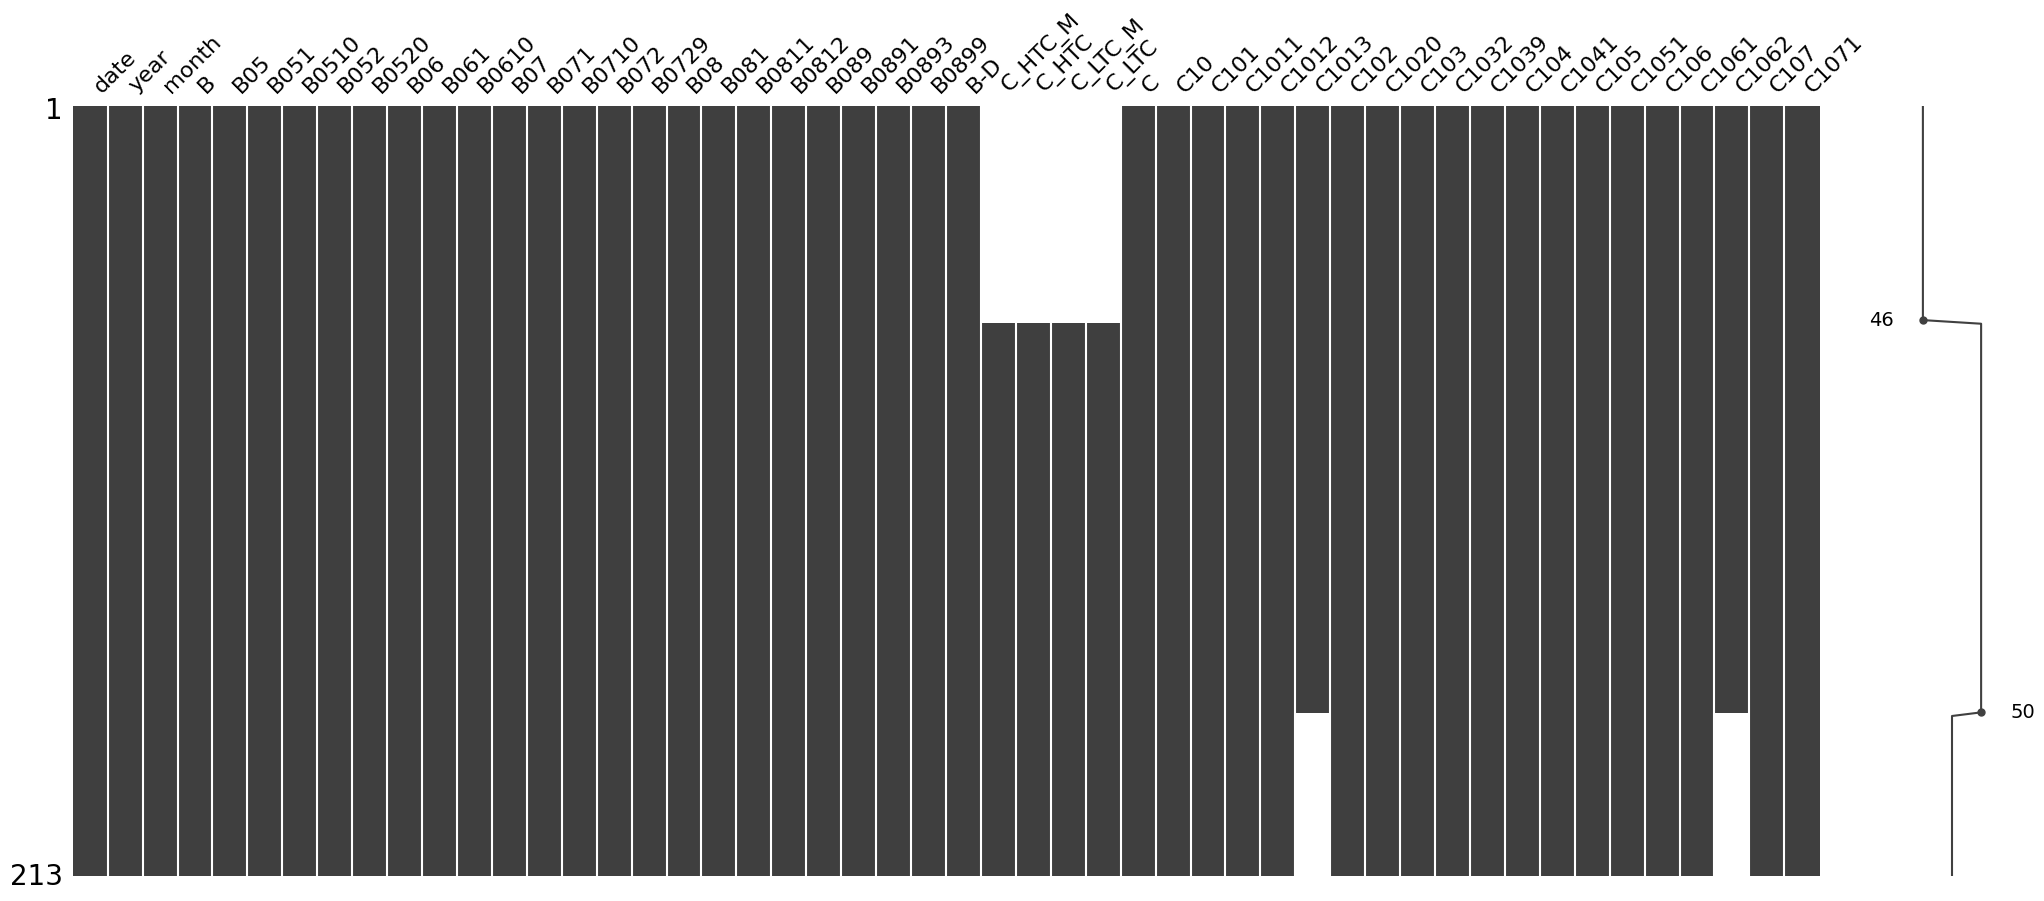

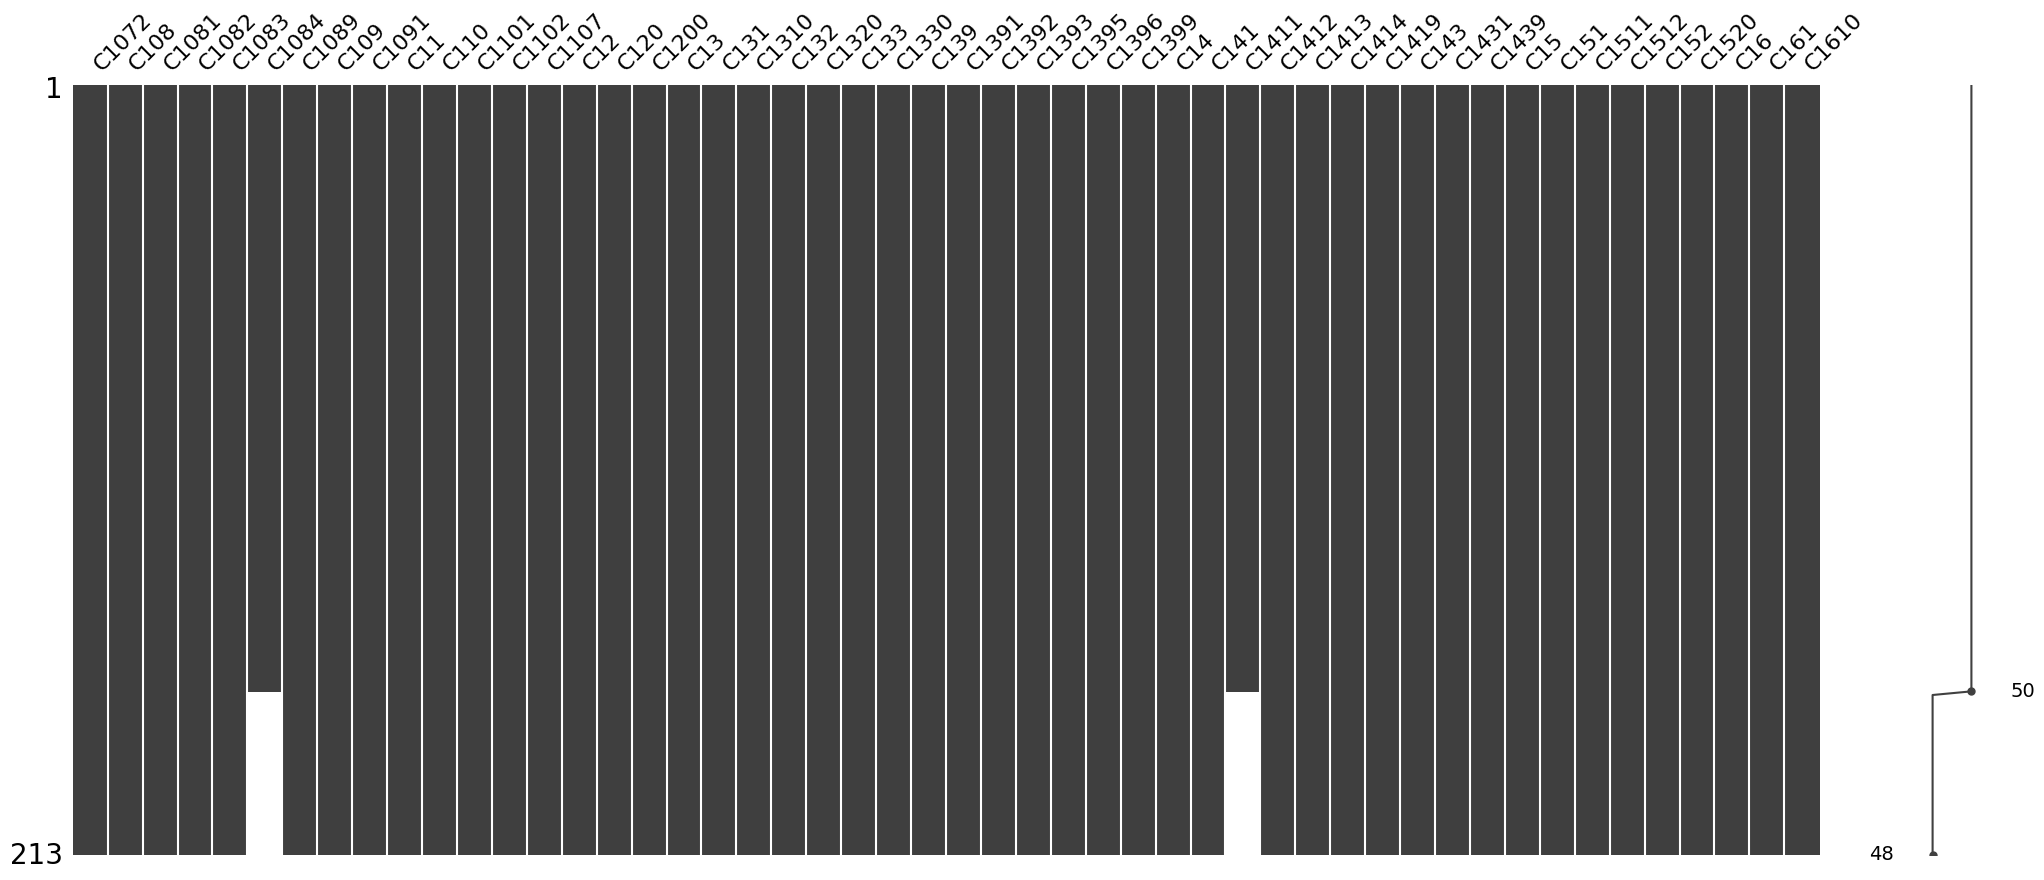

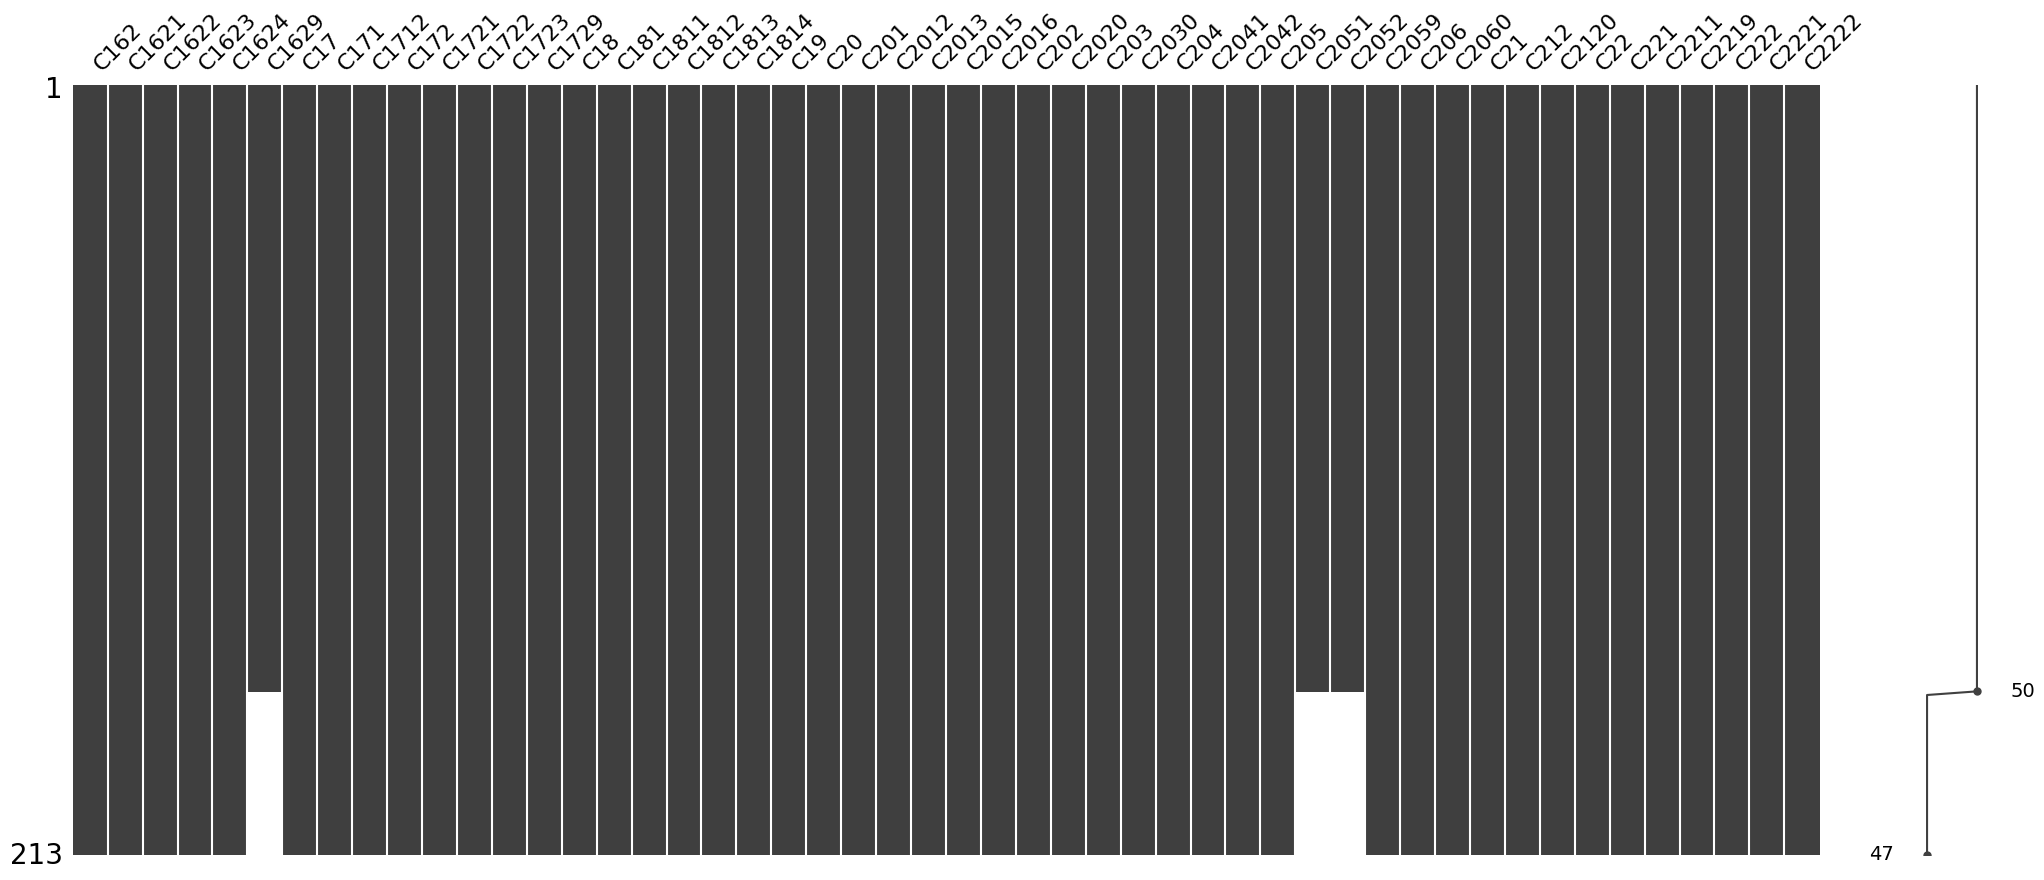

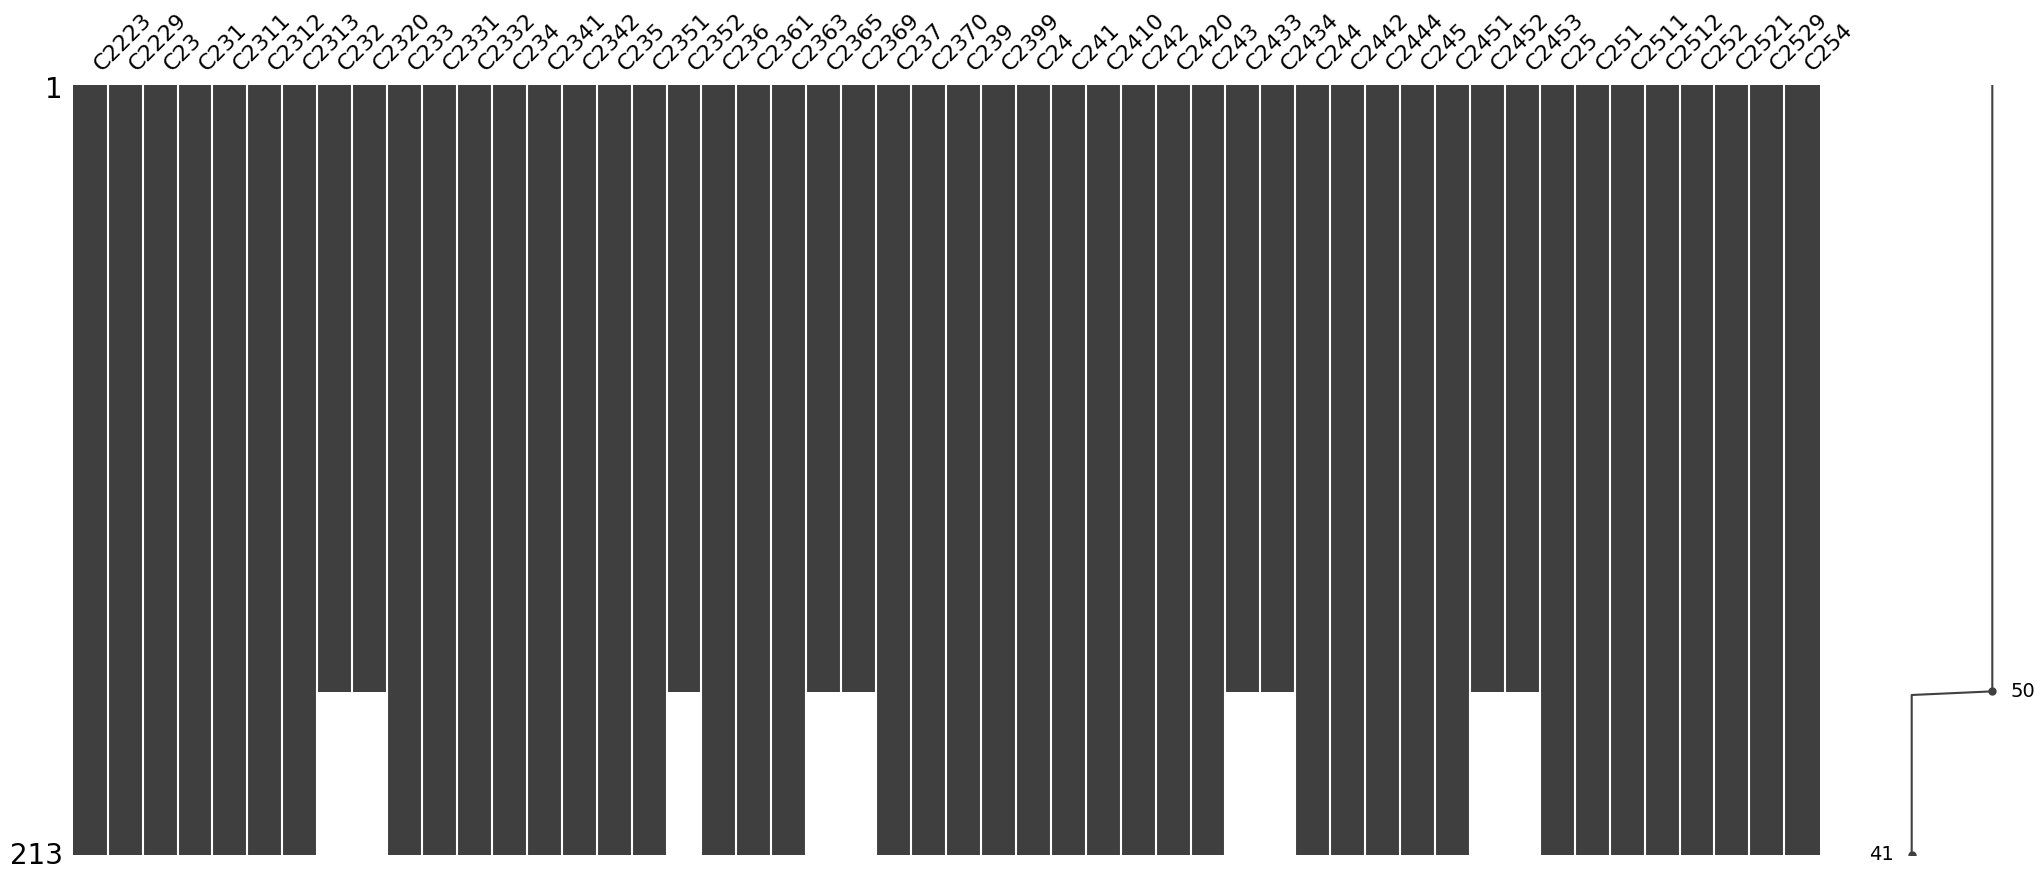

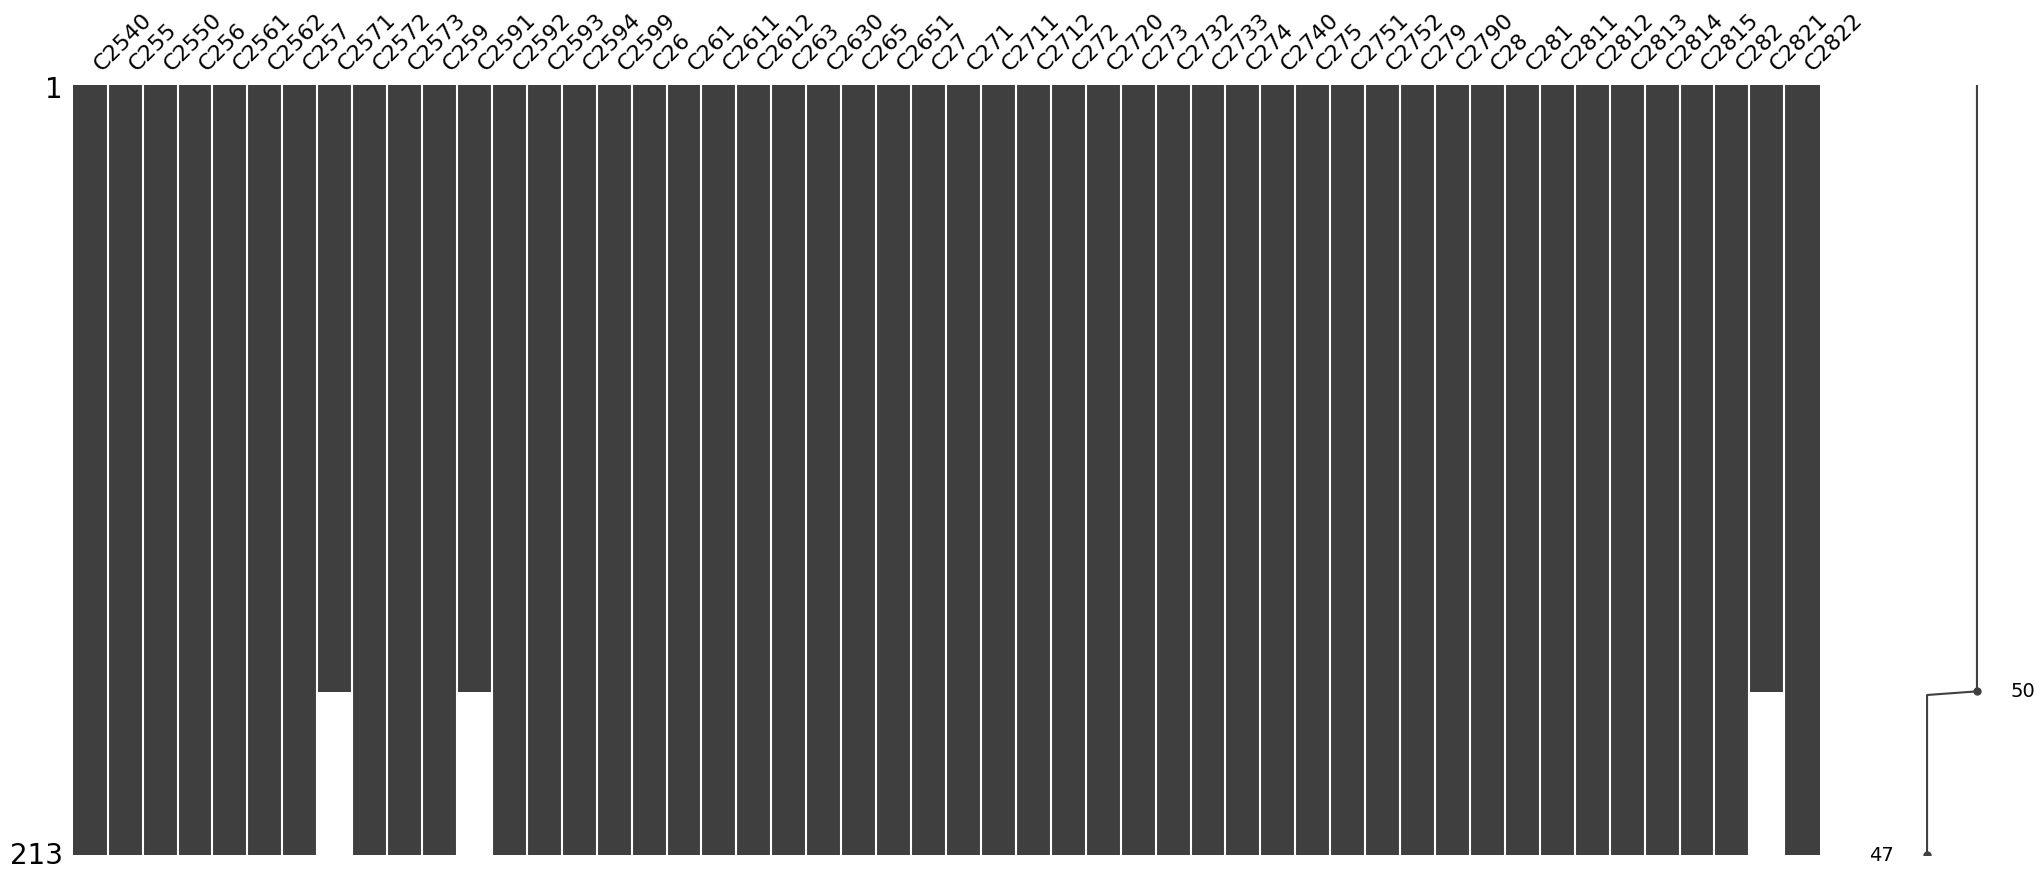

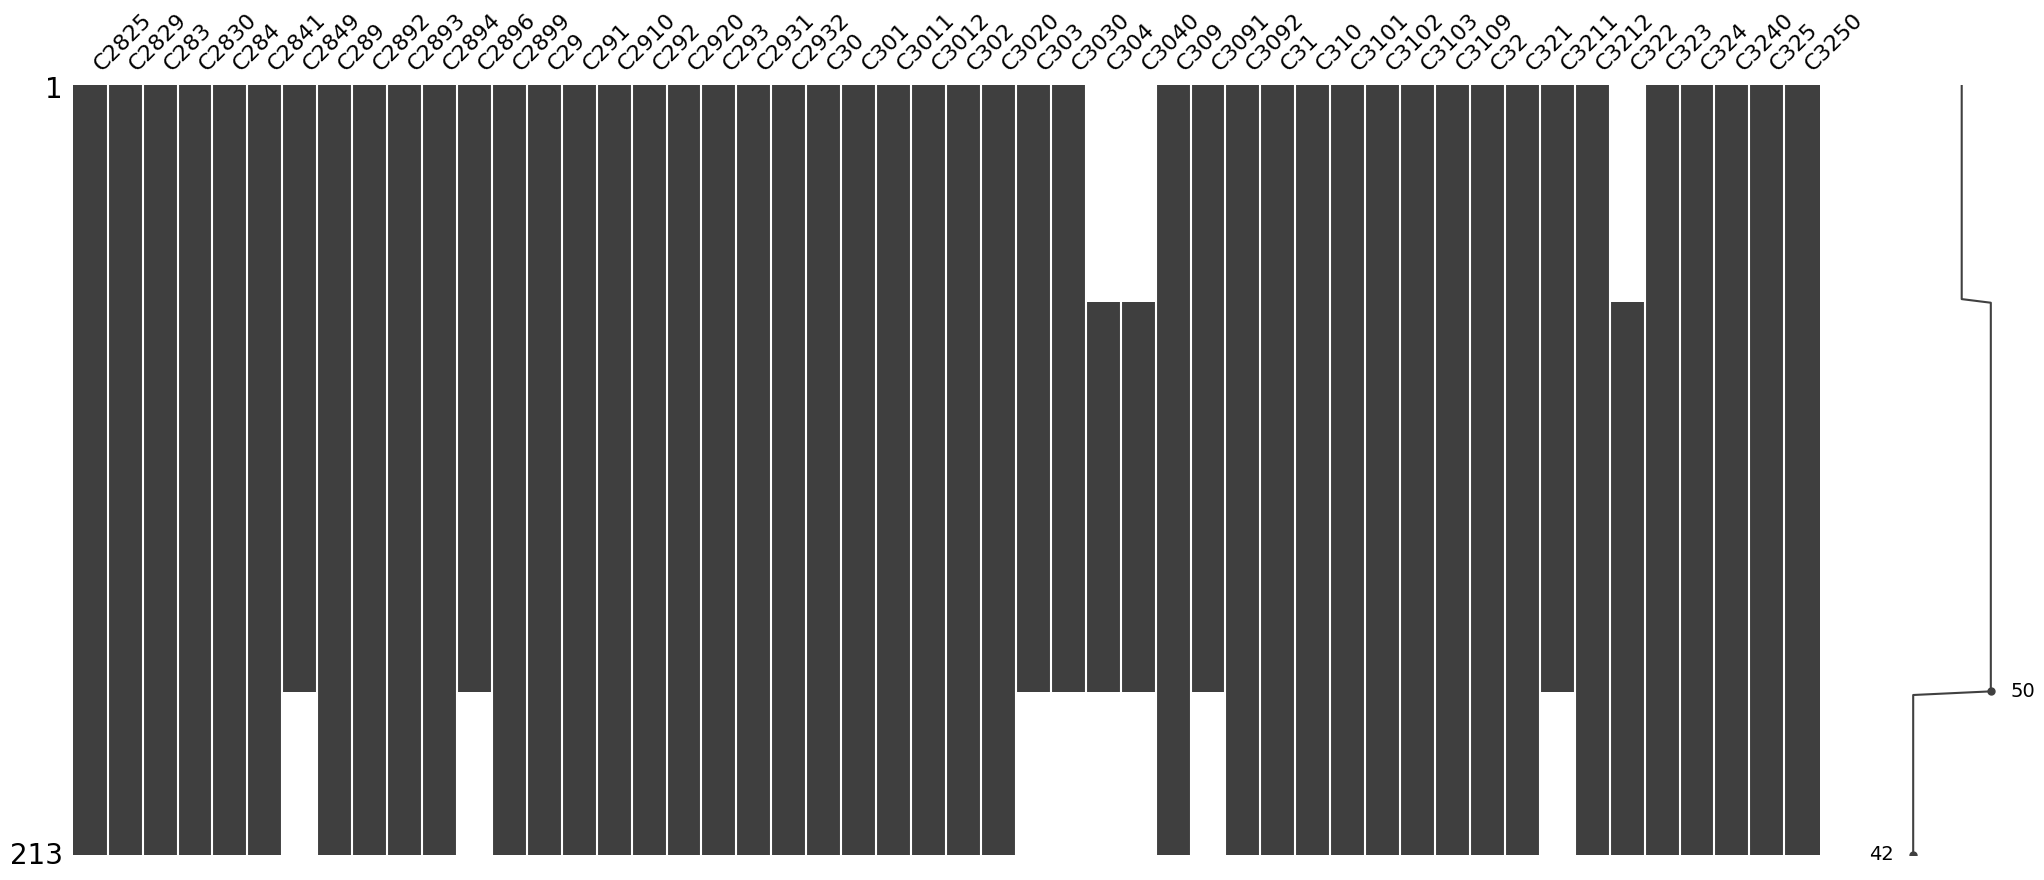

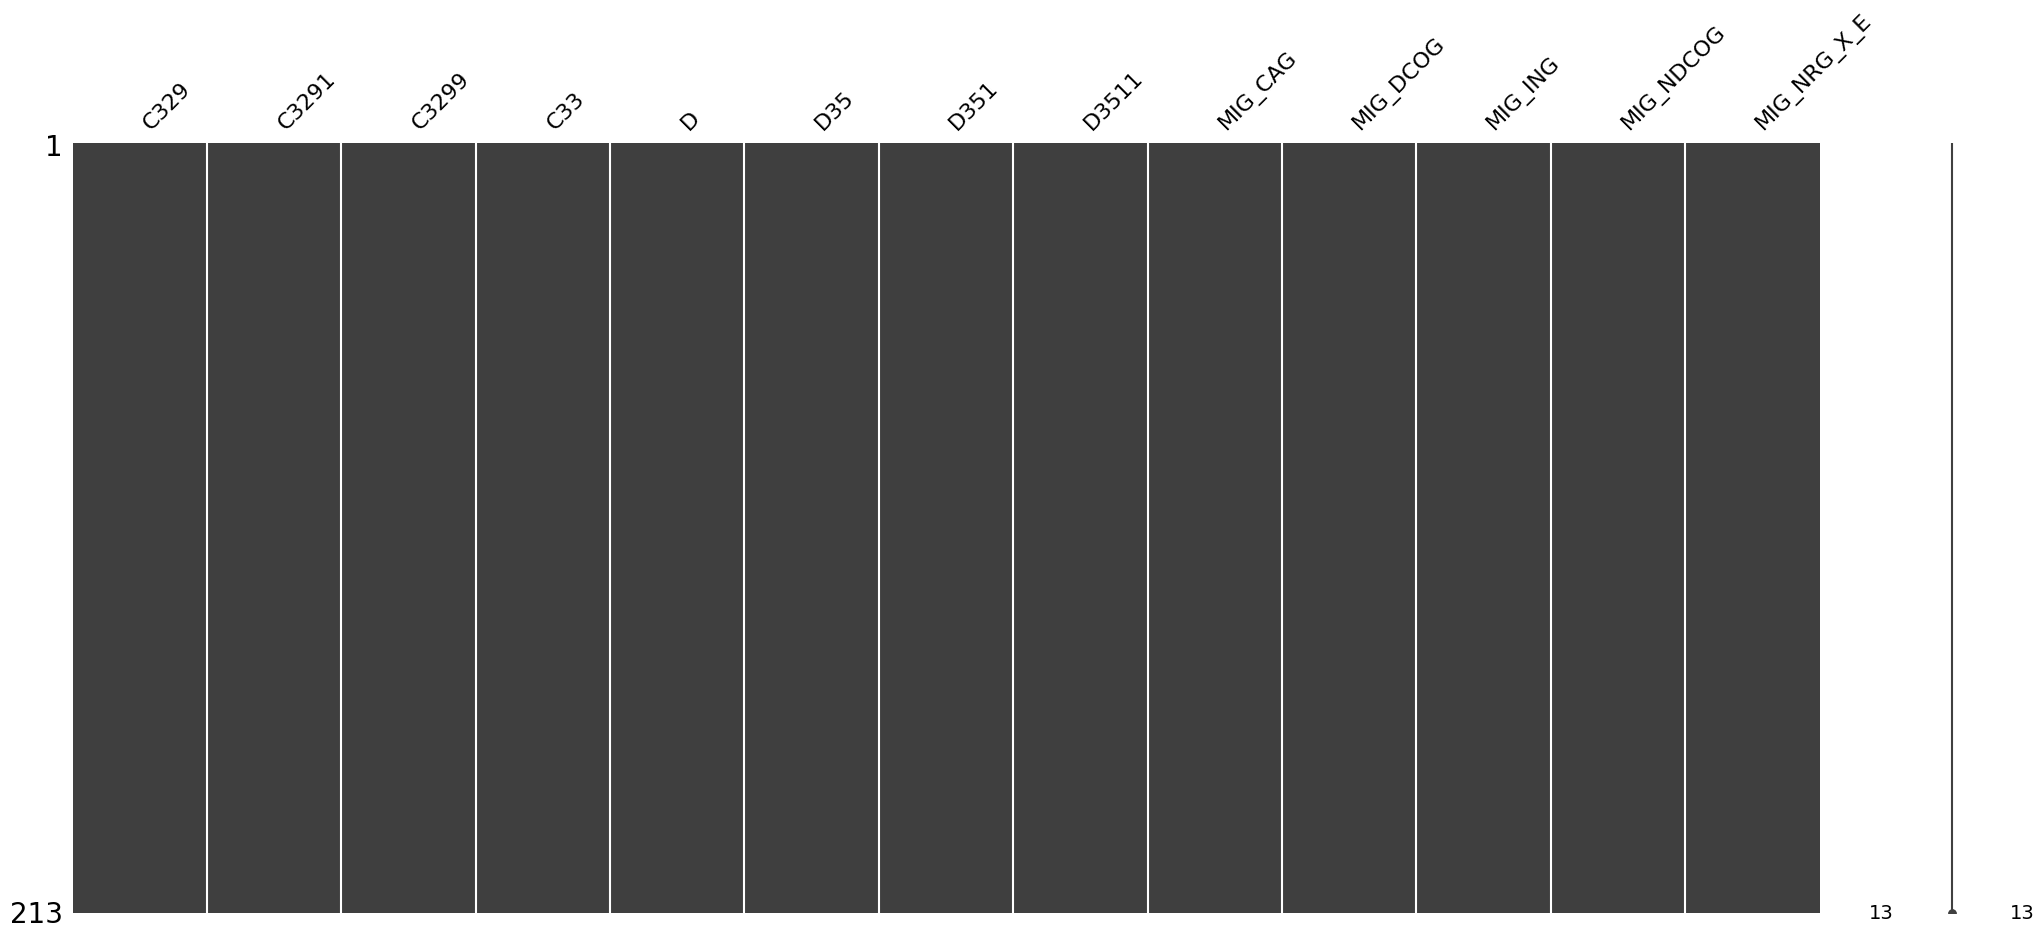

In [268]:
prev_i = 0
for i in range(50, df.columns.shape[0]+50, 50):
    
    msno.matrix(df.iloc[:, prev_i:i])
    plt.show()
    prev_i = i

In [269]:
# Count of missing values in all columns with at least one missing value
cond = df.isna().sum() > 0
df.isna().sum()[cond]

C_HTC_M     60
C_HTC       60
C_LTC_M     60
C_LTC       60
C1013       45
C1062       45
C1084       45
C1411       45
C1629       45
C2051       45
C2052       45
C232        45
C2320       45
C2352       45
C2365       45
C2369       45
C2433       45
C2434       45
C2452       45
C2453       45
C2571       45
C2591       45
C2821       45
C2849       45
C2896       45
C303        45
C3030       45
C304       105
C3040      105
C3091       45
C3211       45
C322        60
dtype: int64

Since all of the columns with missing values have at least 45 missing values (almost 4 years), and the missing values are all back to back, so imputing them will not be possible, these values will be dropped.

In [270]:
cols_to_drop = cond[cond].index
df = df.drop(columns=cols_to_drop)

### Correlated indexes
Dropping indexes that are completely correlated (Corr = 1) with other indexes

In [271]:
# Boolean dataframe of columns that have correlation 1
correlated_cols = df.iloc[:, 3:].corr() == 1

# Each row of the boolean dataframe (corrresponding to columns that have corr=1) should have
# only one True value, which is the correlation of the column with itself
# Whenever we have more than one True value it means that we have two different columns
# having corr = 1
# Therefore, columns with more than one True values are to be dropped

cond = correlated_cols.sum(axis=1) > 1
cols_to_drop = cond[cond].index
df = df.drop(columns=cols_to_drop)
print(f'{cols_to_drop.shape[0]} fully correlated columns have been dropped.')

73 fully correlated columns have been dropped.


In [272]:
# Checking if all correlated columns have been dropped
correlated_cols = df.iloc[:, 3:].corr() == 1
cond = correlated_cols.sum(axis=1) > 1
cond.sum()

0

In [273]:
df.shape

(213, 208)

In [277]:
# Saving file
path = 'cleaned_data/industrial_production_index.csv'
# df.to_csv(path, index=False)

# Loading saved_data
df = pd.read_csv(path, parse_dates=['date'])

In [278]:
df.head()

,date,year,month,B,B05,B06,B07,B08,B081,B0811,...,C323,C329,C3291,C3299,C33,MIG_CAG,MIG_DCOG,MIG_ING,MIG_NDCOG,MIG_NRG_X_E
0,2005-01-01,2005,1,59.0,97.9,90.9,18.0,49.4,44.3,37.7,...,2.0,67.2,45.4,75.0,35.8,36.1,50.3,48.3,55.5,67.5
1,2005-02-01,2005,2,60.3,110.3,83.3,18.4,49.3,44.2,35.4,...,0.2,68.4,35.0,78.5,39.6,42.0,50.1,50.7,54.2,64.9
2,2005-03-01,2005,3,58.2,90.0,93.0,18.8,50.4,42.7,43.7,...,4.4,81.4,54.2,91.0,43.6,50.5,60.1,58.2,62.3,68.9
3,2005-04-01,2005,4,58.9,86.7,88.2,21.0,55.4,48.6,52.3,...,4.2,67.7,28.4,78.8,43.8,49.1,60.7,57.5,57.6,65.2
4,2005-05-01,2005,5,64.3,86.2,91.5,36.9,59.5,53.5,63.9,...,6.6,79.2,39.8,91.0,42.2,52.1,58.2,60.7,60.1,66.8
